In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm.notebook import tqdm
import scipy.signal
import IPython.display

from rlbase import misc
from rlbase.environment import RandomWalkEnvironment, WindyGridworldEnvironment, CliffGridworldEnvironment,\
Ex67Environment
from rlbase.policy import DeterministicPolicy, EpsGreedy
from rlbase.agent import SarsaAgent, QlearningAgent, ExpectedSarsaAgent, DoubleQlearningAgent
from rlbase.experiment import TD_CtrlExperiment
from rlbase.policy_functions import *

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

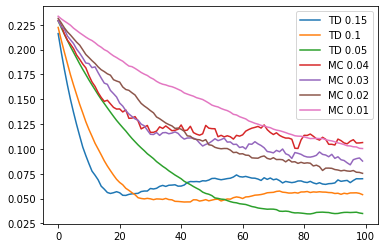

In [2]:
s0 = 3
N = 2*s0-1

env = RandomWalkEnvironment(nmax=N)
pi = DeterministicPolicy(env=env)

v_true = evaluate_policy_linear_system(env,pi)
v_true = [v for v in v_true.values()]

gamma = 1

runs = 100
n_episodes = 100

legends = []
for alpha in tqdm([0.15,0.1,0.05,0.04,0.03,0.02,0.01]):
  e_mc = np.zeros((n_episodes,1))
  e_td = np.zeros((n_episodes,1))
  for run in tqdm(range(runs),leave=False):
    v_init = np.ones((N+2,1))*0.5
    v_mc = v_init.copy()
    v_td = v_init.copy()
        
    for i in range(n_episodes):
      s = s0
      episode = []
      while True:
        r, s_prime, terminal = env.step(s,0)
        episode += [(s,r)]
        if terminal:
          v_td[s] += alpha * (r - v_td[s] )
          break
        else:
          v_td[s] += alpha * (r + gamma * v_td[s_prime] - v_td[s])
        s = s_prime
      G = 0
      for (s,r) in episode[::-1]:
        G = gamma * G + r
        v_mc[s] += alpha * ( G - v_mc[s] )  
      e_mc[i] += (np.sum((v_mc[1:N+1]-v_true[1:N+1])**2))**.5/runs/5**.5
      e_td[i] += (np.sum((v_td[1:N+1]-v_true[1:N+1])**2))**.5/runs/5**.5
  if alpha>=0.05:
    plt.plot(e_td)
    legends += ["TD "+str(alpha)]
  else:
    plt.plot(e_mc)
    legends += ["MC "+str(alpha)]
plt.legend(tuple(legends))  

<IPython.core.display.Javascript object>

100%|██████████| 1000/1000 [00:09<00:00, 105.43it/s]


<IPython.core.display.Javascript object>


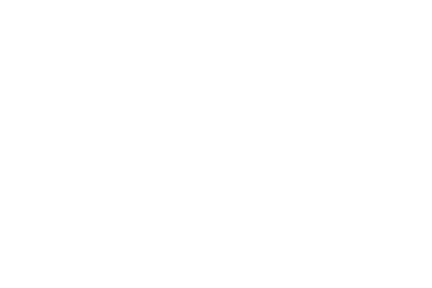

In [3]:
%matplotlib notebook

lens = []
timesteps = [0]
eee = []
fig, _ = plt.subplots(6,2,figsize=(5,7))
def plot(i,episode):
  global lens, timesteps
  lens += [len(episode)]
  timesteps += [timesteps[-1]+len(episode)]
  if i%100==0:
    plt.clf()
    x = [a[0][0] for a in episode] + [env.terminal_states[0][0]]
    y = [a[0][1] for a in episode] + [env.terminal_states[0][1]]
    
    for idx, di in enumerate(["up","down","left","right"]):
        plt.subplot(6,2,idx+1)
        r = {s: agent.q[s][di] for s in env.states}
        plt.imshow(np.transpose(np.flip(env.reshape(r),axis=1)),origin="lower")
        plt.colorbar()
        plt.title(di)
    best_action = {k:misc.argmax_unique(v) for (k,v) in agent.q.items()}
    
    arrow_length = .3
    
    plt.subplot(6,2,(5,8))
    for j in range(env.sx+1):
      plt.plot([j-.5,j-.5],[-.5,env.sy-.5],'k-')
    for j in range(env.sy+1):
      plt.plot([-.5,env.sx-.5],[j-.5,j-.5],'k-')
    for (k,v) in best_action.items():
      dx, dy = (0,0)
      if "right" in v:
        dx += arrow_length
      if "up" in v:
        dy += arrow_length
      if "left" in v:
        dx -= arrow_length
      if "down" in v:
        dy -= arrow_length
      plt.arrow(k[0],k[1],dx,dy,color="r",head_width=0.1)
    for xx in [3,4,5,5.95,6.05,6.95,7.05,8]:
      plt.plot([xx,xx],[0,6],dx,dy,color="b")
    plt.xlim(-.5,env.sx-.5)
    plt.ylim(-.5,env.sy-.5)
    plt.plot(env.start[0],env.start[1],"ob",markersize=12)
    plt.plot(env.terminal_states[0][0],env.terminal_states[0][1],"og",markersize=12)
    
    plt.subplot(6,2,(9,12))
    plt.plot(x,y,'-xk')
    for j in range(env.sx+1):
      plt.plot([j-.5,j-.5],[-.5,env.sy-.5],'k-')
    for j in range(env.sy+1):
      plt.plot([-.5,env.sx-.5],[j-.5,j-.5],'k-')
    for a in episode:
      dx, dy = (0,0)
      if "right" in a[1]:
        dx += arrow_length
      if "up" in a[1]:
        dy += arrow_length
      if "left" in a[1]:
        dx -= arrow_length
      if "down" in a[1]:
        dy -= arrow_length
      plt.arrow(a[0][0],a[0][1],dx,dy,color="r",head_width=0.1)
    for xx in [3,4,5,5.95,6.05,6.95,7.05,8]:
      plt.plot([xx,xx],[0,6],dx,dy,color="b")
    plt.xlim(-.5,env.sx-.5)
    plt.ylim(-.5,env.sy-.5)
    plt.plot(env.start[0],env.start[1],"ob",markersize=12)
    plt.plot(env.terminal_states[0][0],env.terminal_states[0][1],"og",markersize=12)
    
    fig.canvas.draw()

env = WindyGridworldEnvironment(diagonal=False,stay=False)
pi = EpsGreedy(env=env,eps=0.1)
agent = SarsaAgent(env=env,pi=pi)
exp = TD_CtrlExperiment(env=env,agent=agent,n_episodes=1000,callback=plot)
exp.train()
plt.figure()
plt.plot(timesteps,list(range(len(timesteps))))

  0%|          | 0/100 [00:00<?, ?it/s]

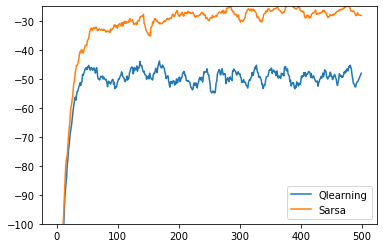

In [4]:
%matplotlib inline
rewards = []

def count(i,episode):
  global rewards
  rewards += [sum(r for s,a,r in episode)]
    
env = CliffGridworldEnvironment()
pi = EpsGreedy(env=env,eps=0.1)
all_rewards = {"Qlearning":np.zeros(500),"Sarsa":np.zeros(500)}

for i in tqdm(range(100)):
    lens = []
    timesteps = [0]
    rewards = []
    agent = QlearningAgent(pi=pi,env=env)
    exp = TD_CtrlExperiment(env=env,agent=agent,n_episodes=500,callback=count,show_progress=False)
    exp.train()
    all_rewards["Qlearning"] += rewards

    lens = []
    timesteps = [0]
    rewards = []
    agent = SarsaAgent(pi=pi,env=env)
    exp = TD_CtrlExperiment(env=env,agent=agent,n_episodes=500,callback=count,show_progress=False)
    exp.train()
    all_rewards["Sarsa"] += rewards
    
plt.plot(scipy.signal.savgol_filter(all_rewards["Qlearning"]/100,window_length=11,polyorder=1))
plt.plot(scipy.signal.savgol_filter(all_rewards["Sarsa"    ]/100,window_length=11,polyorder=1))
plt.ylim([-100,-25])
plt.legend(all_rewards.keys())


  0%|          | 0/114 [00:00<?, ?it/s]

(-160.0, 0.0)

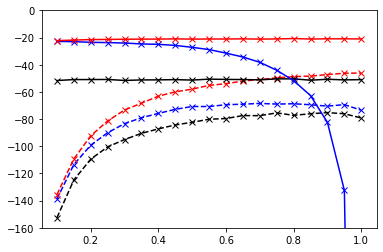

In [5]:
alphas = [0.1+i*0.05 for i in range(19)]

algos = ["Qlearning","Sarsa","ExpectedSarsa"]
typs = ["interim","asymptotic"]

runs     = {"interim": 50000, "asymptotic": 10}
episodes = {"interim": 100, "asymptotic": 100000}

runs     = {"interim": 100, "asymptotic": 10}
episodes = {"interim": 100, "asymptotic": 10000}

rewards = 0
def count(i,episode):
  global rewards
  rewards += sum(r for s,a,r in episode)

combs = [(typ,algo,alpha) for typ in typs for algo in algos for alpha in alphas]
    
all_rewards = {comb:0 for comb in combs}
env = CliffGridworldEnvironment()
for (typ,algo,alpha) in tqdm(combs):
    pi = EpsGreedy(env=env,eps=0.1)
    for i in range(runs[typ]):
        rewards = 0
        if algo=="Qlearning":
            agent = QlearningAgent(pi=pi,env=env,alpha=alpha)
        elif algo=="Sarsa":
            agent = SarsaAgent(pi=pi,env=env,alpha=alpha)
        elif algo=="ExpectedSarsa":
            agent = ExpectedSarsaAgent(pi=pi,env=env,alpha=alpha)
        exp = TD_CtrlExperiment(env=env,agent=agent,n_episodes=episodes[typ],callback=count,show_progress=False)
        exp.train()
        all_rewards[(typ,algo,alpha)] += rewards / episodes[typ] / runs[typ]

col ={"Sarsa":"b","Qlearning":"k","ExpectedSarsa":"r"}
lty = {"interim":"--","asymptotic":"-"}

d ={(typ,algo):[] for typ in typs for algo in algos}
for (typ,algo,alpha) in combs:
    d[(typ,algo)] += [all_rewards[(typ,algo,alpha)]]
for typ in typs:
    for algo in algos:
        plt.plot(alphas,d[(typ,algo)],col[algo]+lty[typ]+"x")
plt.ylim([-160,0])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


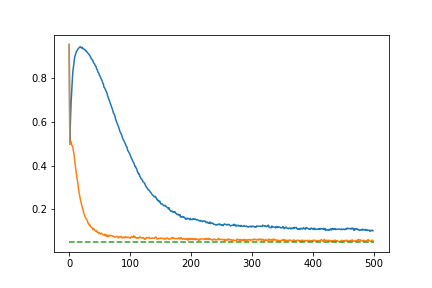

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
%matplotlib notebook

n_episodes = 500
n_runs = 10000

def save_data(i,episode):
  global tmp
  if episode[0][1]=="l":
    tmp[i] += 1

all_mid = {}
for algo in tqdm(["Q","DoubleQ"]):
    tmp = np.zeros(n_episodes)
    for i in tqdm(range(n_runs)):
        env = Ex67Environment(n=10)
        pi = EpsGreedy(env=env,eps=0.1)
        if algo=="Q":
            agent = QlearningAgent(env=env,pi=pi,alpha=0.1)
        else:
            agent = DoubleQlearningAgent(env=env,pi=pi,alpha=0.1)
        exp = TD_CtrlExperiment(env=env,agent=agent,n_episodes=n_episodes,callback=save_data,show_progress=False)
        exp.train()
    all_mid[algo] = tmp / n_runs

plt.figure()
for algo in tqdm(["Q","DoubleQ"]):
    plt.plot(all_mid[algo],"-")
plt.plot([0,n_episodes],[0.05,0.05],"--")